In [11]:
library(tidyverse)
library(ggplot2)

In [12]:
vuln <- read_csv("../permanently_saved_results/arjun-vuln-exp/aug_27_gather.csv",
        col_types ="ccfddfc")

In [13]:
head(vuln)

name,commit,solver,CVE,NDeps,Status,Time
<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<chr>
docusign-node-client,423f93e,vanilla,105.8,52,success,NA
docusign-node-client,423f93e,audit fix,105.8,52,success,NA
docusign-node-client,423f93e,audit fix force,0.0,67,success,NA
docusign-node-client,423f93e,maxnpm_cve_oldness,94.9,50,success,NA
docusign-node-client,423f93e,maxnpm_cve_oldness_pip_else_npm,94.9,50,success,NA
ember-component-css,489f23f,vanilla,106.9,240,success,NA


In [14]:
# What does it mean when status is "missing" - and should we only include those that have no missing?
# There are 225/1000 project-versions that have non-NA results: what is missing there?
vulnByProject <- vuln %>%
    replace_na(list(CVE=-1)) %>%
    pivot_wider(names_from=solver, values_from=CVE, names_prefix="CVE.") %>%
    group_by(name,commit) %>%
    summarise(across(starts_with("CVE."), ~sum(.x,na.rm=TRUE))) %>% ungroup() %>%
    filter(`CVE.audit fix` >= 0 & `CVE.audit fix force`>=0 & `CVE.maxnpm_cve_oldness`>=0) 
head(vulnByProject)
nrow(vulnByProject)

`summarise()` has grouped output by 'name'. You can override using the `.groups` argument.



name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accord,1e5a62b,0,44.4,0,0,0
accord,2362ca4,0,57.2,0,0,0
accord,391b1c0,0,0.0,0,0,0
accord,47b5d29,0,0.0,0,0,0
accord,53ef3ed,0,51.9,0,0,0
acorn-node,11b3621,0,0.0,0,0,0


[1] 394

## How many times did MaxNPM come to a different CVE score than NPM audit fix?

In [15]:
breaks <- c(0, 1, 10, 25, 50, 100, 1000)
bucketedVuln <- vulnByProject %>%
    mutate(across(starts_with('CVE'), ~cut_format(.x, breaks=breaks))) %>% # Bucket all CVE columns
    mutate_if(is.factor, as.character) %>%  # Default is these are factors, make them char so easier to handle
    mutate(across(starts_with('CVE'), ~replace(.,is.na(.), '0'))) %>% # If it was NA, it was because it was outside of the range, aka == 0
    group_by(`CVE.audit fix`,`CVE.maxnpm_cve_oldness`) %>% summarise(count=n()) %>%
    # Sum the count for CVE audit fix and add a row for that called 'total'
    bind_rows(group_by(.,`CVE.audit fix`) %>%
        summarise(count=sum(count)) %>%
        mutate(`CVE.maxnpm_cve_oldness`='Total')) %>%
    bind_rows(group_by(.,`CVE.maxnpm_cve_oldness`) %>%
        summarise(count=sum(count)) %>%
        mutate(`CVE.audit fix`='Total'))

# Create a matrix where the columns are for audit fix, rows are for MaxNPM
bucketedVuln %>%
    pivot_wider(names_from=`CVE.audit fix`, values_from=count) %>%
    relocate(`0`, .before=`(   1,   10]`) %>%
    mutate_if(is.numeric,~replace(.,is.na(.), 0)) %>%
    arrange(CVE.maxnpm_cve_oldness) #%>%
        # kable("html", booktabs=TRUE, linesep="", digits=0, escape=FALSE, format.args = list(big.mark = ",",
        #   scientific = FALSE)) %>% as.character() %>% display_html()

`summarise()` has grouped output by 'CVE.audit fix'. You can override using the `.groups` argument.



CVE.maxnpm_cve_oldness,0,"( 1, 10]","( 10, 25]","( 25, 50]","( 50, 100]","( 100, 1000]",Total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"( 1, 10]",0,44,1,1,0,0,46
"( 10, 25]",0,0,60,13,1,1,75
"( 25, 50]",0,0,0,56,4,0,60
"( 50, 100]",0,0,0,0,52,4,56
"( 100, 1000]",0,0,0,0,0,14,14
0,133,5,2,1,2,0,143
Total,133,49,63,71,59,19,394


## Which were the cases that MaxNPM better?

In [16]:
vulnByProject %>% filter(`CVE.maxnpm_cve_oldness` < `CVE.audit fix`)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accord,1e5a62b,0.00,44.40,0.00,0.00,0.00
accord,2362ca4,0.00,57.20,0.00,0.00,0.00
accord,53ef3ed,0.00,51.90,0.00,0.00,0.00
adbkit,7d0ec60,0.00,2.00,0.00,0.00,0.00
ampersand-sync,fcc58ef,0.00,17.30,0.00,0.00,0.00
artillery,bcac1d6,157.05,157.05,119.75,153.05,153.05
asset-pipe-build-server,326528a,115.80,115.80,0.00,104.90,104.90
asset-pipe-build-server,45f35cd,73.30,73.30,0.00,71.30,71.30
asset-pipe-build-server,95d0825,73.30,73.30,0.00,71.30,71.30


## When MaxNPM outperformed NPM Audit, how much better was it?

Negative numbers are *better* because they are a decrease in badness.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



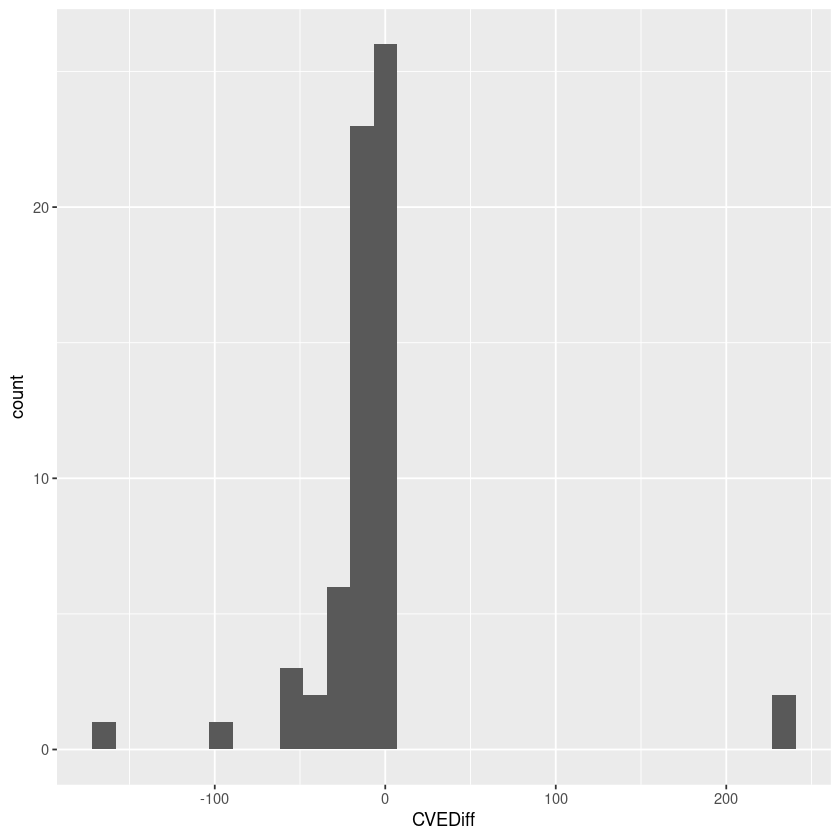

In [25]:
CVEDiff <- vulnByProject %>%
    mutate(CVEDiff=`CVE.maxnpm_cve_oldness` - `CVE.audit fix`) %>%
    filter(CVEDiff != 0)
    
ggplot(CVEDiff, aes(x=CVEDiff)) + geom_histogram()

In [26]:
# These are the ones where MaxNPM did worse somehow?
CVEDiff %>% filter(CVEDiff >0)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
browsertime,8d8bb82,147.8,147.8,2,385.3,385.3,237.5
browsertime,96b8346,147.8,147.8,2,385.3,385.3,237.5


In [27]:
# These are the ones where MaxNPM did the best
CVEDiff %>% arrange(CVEDiff)

name,commit,CVE.vanilla,CVE.audit fix,CVE.audit fix force,CVE.maxnpm_cve_oldness,CVE.maxnpm_cve_oldness_pip_else_npm,CVEDiff
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
connect-modrewrite,ca6ae59,313.55,313.55,0.0,152.15,152.15,-161.40
forever-monitor,7b4d637,116.45,116.45,0.0,16.80,16.80,-99.65
accord,2362ca4,0.00,57.20,0.0,0.00,0.00,-57.20
crawlee,851cec4,71.95,71.95,0.0,15.00,15.00,-56.95
accord,53ef3ed,0.00,51.90,0.0,0.00,0.00,-51.90
accord,1e5a62b,0.00,44.40,0.0,0.00,0.00,-44.40
dagre-d3,0c6770c,88.80,88.80,0.0,44.40,44.40,-44.40
conventional-changelog,293445a,134.60,134.60,22.9,104.40,104.40,-30.20
conventional-changelog,7c48e0d,141.90,141.90,132.8,111.70,111.70,-30.20
